## Assessing Salmon Harvests in Alaska

#### To do:
* link to online file, instead of referencing the local version

In [88]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
%matplotlib inline

#### Clean up the timeseries excel sheet
The historical data separated information by species into different sheets. This code goes through each sheet, adds a column called "species" and then puts all that data into a single dataframe, called all_fish.

#### Adjust dollars for inflation
Adding in a CPI table to convert nominal dollars into 2017 dollars.  
Consult https://www.bls.gov/cpi/cpi1998d.htm to understand how to use the CPI adjustment:  
* CPI for current period (250) **less** CPI for previous period (230) **equals** index point change (20)
* Divide index point change by previous period CPI (230) == 0.0869 to find percent change

In sum: look for percent change in the index between years.

#### The end result is timeseries with fish harvest counts, with nominal and inflation-adjusted values, by species.

In [204]:
# Data source for "2016_12_27  Historical salmon exvessel & number of fish charts.xlsx" was a 
# personal email communication with Jennifer Shriver, ADFG on Tue, Apr 25, 2017 at 2:55 PM.
# jennifer.shriver@alaska.gov

# 1975 through current data is available online at 
# http://www.adfg.alaska.gov/index.cfm?adfg=commercialbyfisherysalmon.salmon_grossearnings_byspecies

fish_species = ['chinook', 'coho', 'sockeye', 'pink', 'chum']

collected_data = ['Year','Harvest (thousands of fish)','Value (nominal dollars)']

all_fish = pd.DataFrame(columns=collected_data)

for fish in fish_species:
    name = fish.upper()+" CHART"
    fish_df = pd.read_excel("2016_12_27  Historical salmon exvessel & number of fish charts.xlsx",
                            sheetname=name,
                            skiprows=32,
                            header=None,
                            names = collected_data,
                            na_values = 0
                           )
    fish_df['Species'] = fish
    all_fish = pd.concat([all_fish,fish_df], axis=0)
    
all_fish['Year'] = all_fish['Year'].astype(int)

# Adjust the nominal harvest dollars for inflation
# Source: US Bureau of Labor Statistics
# Site: https://data.bls.gov/pdq/SurveyOutputServlet

cpi = pd.read_table('CPI_Adjustment_1913_to_2017.csv', skiprows=8, sep=',')
# Make a new column for inflation-adjusted values
CPI2017 = cpi[cpi['Year']==2017]['Annual'].values[0]

cpi['2017 multiplier'] = (CPI2017 - cpi['Annual'])/cpi['Annual']
# 2017 multiplier is how much a 1913 dollar would buy in 2017 dollars

all_fish = pd.merge(all_fish, cpi[['2017 multiplier', 'Year']], on='Year')
#del all_fish['Annual']

all_fish['Value (2017 dollars)'] = all_fish['Value (nominal dollars)']*all_fish['2017 multiplier']
all_fish.head()

,Harvest (thousands of fish),Species,Value (nominal dollars),Year,2017 multiplier,Value (2017 dollars)
0,508.00,chinook,nan,1913,23.65,nan
1,796.00,coho,nan,1913,23.65,nan
2,"28,373.00",sockeye,nan,1913,23.65,nan
3,"26,773.00",pink,nan,1913,23.65,nan
4,"2,853.00",chum,nan,1913,23.65,nan


#### Information about the Pacific Decadal Oscillation

The PDO is an ocean phenomonon that periodically changes the dominant temperature regime in the North Pacific. The PDO index tracks where the PDO is within its cycle.  

In [205]:
pdo = pd.read_table('PDO.latest.txt',skiprows=33, delim_whitespace=True, skipfooter=16,
                    # change the column headers to integer months instead of text abbreviation months
                    names = ['YEAR','1','2','3','4','5','6','7','8','9','10','11','12']
                   )

# remove the ** on the years after 2002, convert this string column to integers
pdo['YEAR'] = pdo['YEAR'].str.replace("\*\*","").astype(int)

# convert this wide data to long data by changing the month columns into a variable
# called month and the value in the cell to the column "PDO Index"
# and separate them based on the "year"

pdo = pdo.melt(var_name='MONTH', value_name='PDO index', id_vars=['YEAR'])
pdo['MONTH'] = pdo['MONTH'].astype(int)
pdo.sort_values(by=['YEAR','MONTH'], ascending=True, inplace=True)
pdo.head()

/Users/kasiana.mclenaghan/.virtualenvs/somaclass/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


,YEAR,MONTH,PDO index
0,1900,1,0.04
118,1900,2,1.32
236,1900,3,0.49
354,1900,4,0.35
472,1900,5,0.77


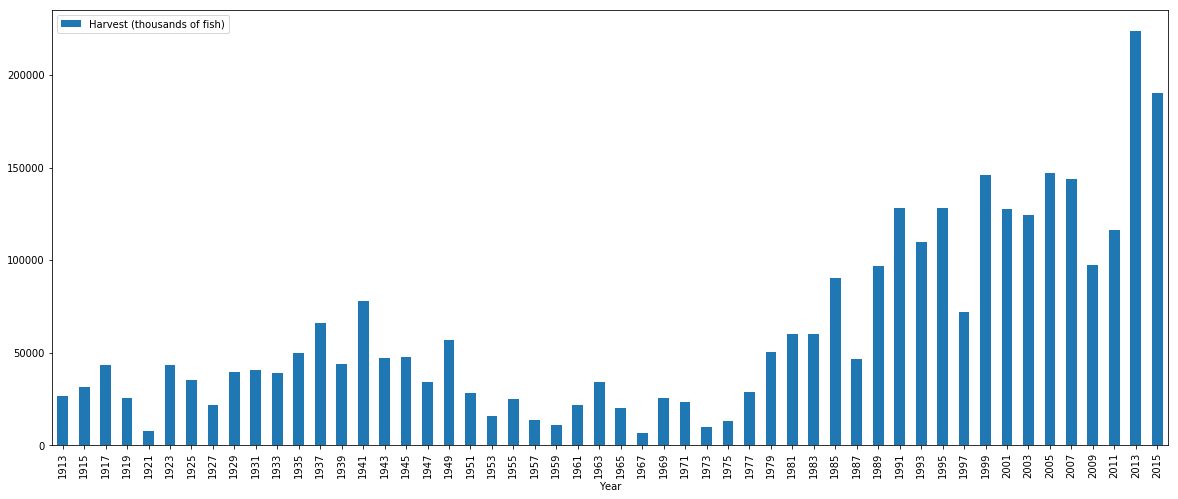

In [202]:
pinks = all_fish['Species']=='pink'
odd_years = (all_fish['Year'] % 2 > 0)
even_years = (all_fish['Year'] % 2 == 0)


all_fish[pinks & odd_years].plot(x='Year',y='Harvest (thousands of fish)', kind='bar', figsize=(20,8))